In [1]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [21]:
ultrasound_fullname = r"j:\Data\ProstateCatheter\Stacked Arrays\Training\stacked_image_array.npy"
segmentation_fullname = r"j:\Data\ProstateCatheter\Stacked Arrays\Training\stacked_segmentation_array.npy"

export_folder = r"j:\Temp"

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))


Found 24 ultrasound images and 24 segmentations


In [3]:
test_ultrasound_fullname = r"j:\Data\ProstateCatheter\Stacked Arrays\Test\test_image_array.npy"
test_segmentation_fullname = r"j:\Data\ProstateCatheter\Stacked Arrays\Test\test_segmentation_array.npy"

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: j:\Data\ProstateCatheter\Stacked Arrays\Test\test_image_array.npy
Reading test segmentation from : j:\Data\ProstateCatheter\Stacked Arrays\Test\test_segmentation_array.npy

Found 6 test ultrasound images and 6 segmentations


In [4]:
# Batch Generator

import keras.utils
import scipy.ndimage

max_rotation_angle = 10
max_shift = 0.2
max_zoom = 0.2

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(128, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            x[i,:,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:,:])
            y[i,:,:,:]= np.flip(self.y[batch_indexes[i],:,:,:])
            
        angle_x = np.random.randint(-max_rotation_angle, max_rotation_angle)
        # rotate x-axis
        x_rot = scipy.ndimage.interpolation.rotate(x, angle_x, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle_x, (1,2), False, mode="constant", cval=0, order=0)
        
        angle_y = np.random.randint(-max_rotation_angle, max_rotation_angle)
        #rotate y-axis
        x_rot = scipy.ndimage.interpolation.rotate(x, angle_y, (0,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle_y, (0,2), False, mode="constant", cval=0, order=0)
        
        angle_z = np.random.randint(-max_rotation_angle, max_rotation_angle)
        #rotate z-axis
        x_rot = scipy.ndimage.interpolation.rotate(x, angle_z, (0,1), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle_z, (0,1), False, mode="constant", cval=0, order=0)

        
        #shift = np.random.uniform(-max_shift, max_shift)
        #x_shift = scipy.ndimage.interpolation.shift(x_rot, shift)
        #y_shift = scipy.ndimage.interpolation.shift(y_rot, shift)
        
        # zoom = np.random.uniform(-max_zoom, max_zoom)
        # x_zoom = scipy.ndimage.interpolation.zoom(x_shift, zoom)
        # y_zoom = scipy.ndimage.interpolation.zoom(y_shift, zoom)
    
        x_aug = np.clip(x_rot, 0.0, 1.0)
        y_aug = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_aug, self.n_classes)

        return x_aug, y_onehot
        

In [5]:
# Prepare dilated output

def dilateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 2
segmentation_dilated = dilateStack(segmentation_data[:, :, :, :, 0], width)

In [6]:
# Uncomment this if you don't want dilation

segmentation_dilated[:, :, :, :] = segmentation_data[:, :, :, :, 0]

In [7]:
num_classes = 2

def nvidia_unet(patch_size=128, num_classes=num_classes):
    input_ = Input((128, 128, 128, 1))
    skips = []
    output = input_
    c = num_classes
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [8, 16, 32, 32, 32, 32, 32]):
        skips.append(output)
        #print("pre_skip")
        #print(output)
        #print(shape)
        output= Conv3D(filters, (3, 3, 3), strides=2, padding="same", activation="relu")(output)
        #print("output3d")
        #print(output)
    
    # output = keras.layers.UpSampling3D(size=(1, 2, 2))(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4], [32, 32, 32, 32, 16, 8, 2]):
        #print(output.shape)
        output = keras.layers.UpSampling3D()(output)
        #print("output2.0:")
        #print(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=4)

        if filters != c:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv3D(filters, (3, 3, 3), activation=activation, padding="same")(output)
        if filters != c:
            output = BatchNormalization(momentum=.9)(output)
        
        print(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(128, num_classes)

# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Tensor("batch_normalization_1/cond/Merge:0", shape=(?, 2, 2, 2, 32), dtype=float32)
Tensor("batch_normalization_2/cond/Merge:0", shape=(?, 4, 4, 4, 32), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 8, 8, 8, 32), dtype=float32)
Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 16, 16, 16, 32), dtype=float32)
Tensor("batch_normalization_5/cond/Merge:0", shape=(?, 32, 32, 32, 16), dtype=float32)
Tensor("batch_normalization_6/cond/Merge:0", shape=(?, 64, 64, 64, 8), dtype=float32)
Tensor("conv3d_14/truediv:0", shape=(?, 128, 128, 128, 2), dtype=float32)


In [8]:
print("Model built with {} parameters".format(model.count_params()))

Model built with 376624 parameters


In [9]:
max_learning_rate = 0.01
min_learning_rate = 0.00001
num_epochs = 250

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy"])

print("Learning rate decay = {}".format(learning_rate_decay))

Learning rate decay = 3.9960000000000004e-05


In [10]:
batch_size = 3

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_data[:, :, :, :, 0], batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/250
8/8 [==============================] - 28s 3s/step - loss: 0.6113 - acc: 0.7307 - val_loss: 0.8992 - val_acc: 0.7914
Epoch 2/250
8/8 [==============================] - 24s 3s/step - loss: 0.3493 - acc: 0.9685 - val_loss: 0.2756 - val_acc: 0.8993
Epoch 3/250
8/8 [==============================] - 27s 3s/step - loss: 0.1169 - acc: 0.9962 - val_loss: 0.0445 - val_acc: 0.9957
Epoch 4/250
8/8 [==============================] - 28s 3s/step - loss: 0.0326 - acc: 0.9970 - val_loss: 0.0209 - val_acc: 0.9971
Epoch 5/250
8/8 [==============================] - 27s 3s/step - loss: 0.0159 - acc: 0.9978 - val_loss: 0.0231 - val_acc: 0.9970
Epoch 6/250
8/8 [==============================] - 25s 3s/step - loss: 0.0155 - acc: 0.9975 - val_loss: 0.0181 - val_acc: 0.9978
Epoch 7/250
8/8 [==============================] - 25s 3s/step - loss: 0.0192 - acc: 0.9969 - val_lo

8/8 [==============================] - 25s 3s/step - loss: 0.0127 - acc: 0.9969 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 61/250
8/8 [==============================] - 25s 3s/step - loss: 0.0161 - acc: 0.9964 - val_loss: 0.0245 - val_acc: 0.9976
Epoch 62/250
8/8 [==============================] - 23s 3s/step - loss: 0.0159 - acc: 0.9974 - val_loss: 0.1991 - val_acc: 0.9176
Epoch 63/250
8/8 [==============================] - 24s 3s/step - loss: 0.0133 - acc: 0.9972 - val_loss: 0.0238 - val_acc: 0.9929
Epoch 64/250
8/8 [==============================] - 26s 3s/step - loss: 0.0222 - acc: 0.9950 - val_loss: 0.0091 - val_acc: 0.9986
Epoch 65/250
8/8 [==============================] - 24s 3s/step - loss: 0.0215 - acc: 0.9970 - val_loss: 0.0105 - val_acc: 0.9982
Epoch 66/250
8/8 [==============================] - 25s 3s/step - loss: 0.0128 - acc: 0.9976 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 67/250
8/8 [==============================] - 25s 3s/step - loss: 0.0119 - acc: 0.9975 - val_loss

Epoch 123/250
8/8 [==============================] - 23s 3s/step - loss: 0.0099 - acc: 0.9972 - val_loss: 0.0080 - val_acc: 0.9977
Epoch 124/250
8/8 [==============================] - 24s 3s/step - loss: 0.0078 - acc: 0.9977 - val_loss: 0.0102 - val_acc: 0.9967
Epoch 125/250
8/8 [==============================] - 23s 3s/step - loss: 0.0080 - acc: 0.9977 - val_loss: 0.0053 - val_acc: 0.9983
Epoch 126/250
8/8 [==============================] - 22s 3s/step - loss: 0.0062 - acc: 0.9982 - val_loss: 0.0076 - val_acc: 0.9974
Epoch 127/250
8/8 [==============================] - 24s 3s/step - loss: 0.0075 - acc: 0.9979 - val_loss: 0.0087 - val_acc: 0.9974
Epoch 128/250
8/8 [==============================] - 25s 3s/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0045 - val_acc: 0.9985
Epoch 129/250
8/8 [==============================] - 25s 3s/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0055 - val_acc: 0.9983
Epoch 130/250
8/8 [==============================] - 25s 3s/step - loss: 0.0062 - a

8/8 [==============================] - 24s 3s/step - loss: 0.0066 - acc: 0.9979 - val_loss: 0.0050 - val_acc: 0.9983
Epoch 186/250
8/8 [==============================] - 25s 3s/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0133 - val_acc: 0.9957
Epoch 187/250
8/8 [==============================] - 24s 3s/step - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0081 - val_acc: 0.9976
Epoch 188/250
8/8 [==============================] - 26s 3s/step - loss: 0.0120 - acc: 0.9964 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 189/250
8/8 [==============================] - 25s 3s/step - loss: 0.0078 - acc: 0.9977 - val_loss: 0.0065 - val_acc: 0.9979
Epoch 190/250
8/8 [==============================] - 25s 3s/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0052 - val_acc: 0.9983
Epoch 191/250
8/8 [==============================] - 24s 3s/step - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0083 - val_acc: 0.9973
Epoch 192/250
8/8 [==============================] - 26s 3s/step - loss: 0.0099 - acc: 0.9972 - v

8/8 [==============================] - 24s 3s/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0044 - val_acc: 0.9985
Epoch 248/250
8/8 [==============================] - 23s 3s/step - loss: 0.0069 - acc: 0.9978 - val_loss: 0.0070 - val_acc: 0.9976
Epoch 249/250
8/8 [==============================] - 23s 3s/step - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0090 - val_acc: 0.9968
Epoch 250/250
8/8 [==============================] - 24s 3s/step - loss: 0.0063 - acc: 0.9980 - val_loss: 0.0068 - val_acc: 0.9976


In [11]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-07-26 00:27:53.292133
Training stopped at: 2019-07-26 02:09:31.485691
Total training time: 1:41:38.193558


In [12]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = r"j:\Data\SavedModels"
model_file_name = "model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

model.save(weights_file_path)
print("Model saved to: {}".format(weights_file_path))

Model saved to: j:\Data\SavedModels\model_2019-07-26_02-09-31.h5


In [13]:
trained_model = load_model(r"j:\Data\SavedModels\model_2019-07-26_00-23-49.h5")
# print(weights_file_path)

In [14]:
y_pred = trained_model.predict(test_ultrasound_data)

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


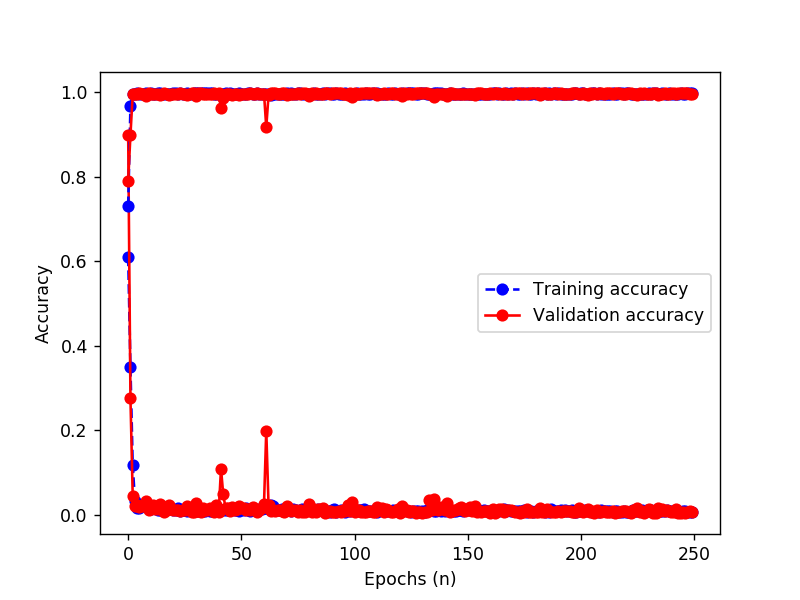

In [16]:
# Display training loss and accuracy curves over epochs

import matplotlib.pyplot as plt

plt.plot(training_log.history['loss'], 'bo--')
plt.plot(training_log.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

plt.plot(training_log.history['acc'], 'bo--')
plt.plot(training_log.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [17]:
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data
import matplotlib.pyplot as plt

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


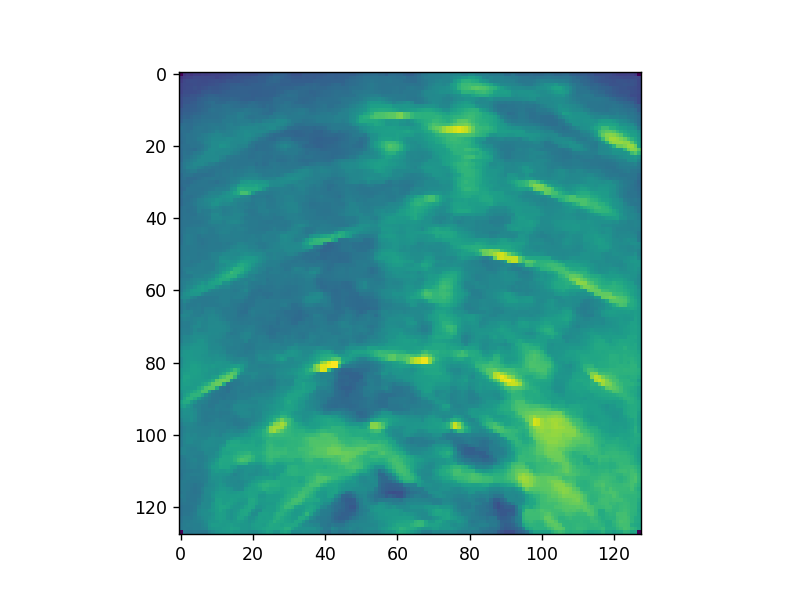

In [18]:
# ultrasound
ultrasound_img = test_ultrasound_data[0]
print(ultrasound_img.shape)
multi_slice_viewer(ultrasound_img[:, :, :, 0])

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


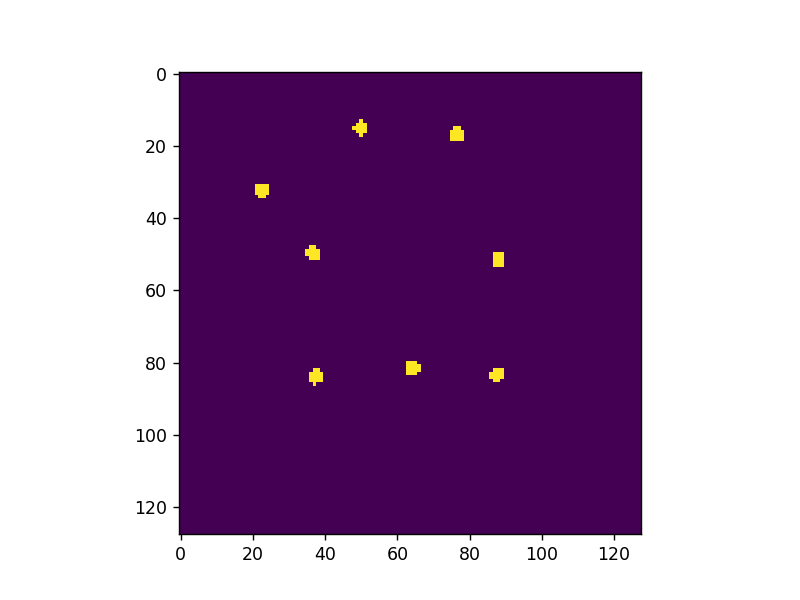

In [19]:
# Segmentation
segmentation_img = test_segmentation_data[0]
print(segmentation_img.shape)
multi_slice_viewer(segmentation_img[:, :, :, 0])

(128, 128, 128, 2)


<IPython.core.display.Javascript object>


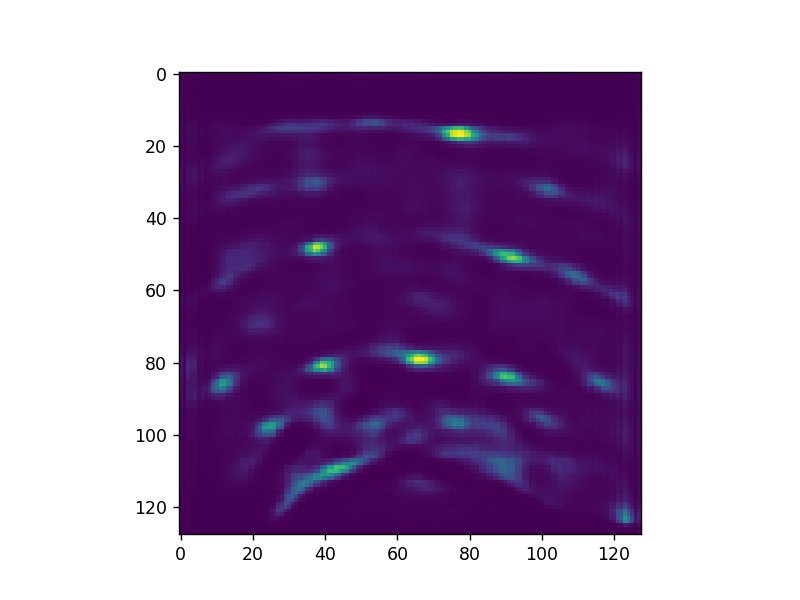

In [20]:
# Prediction
predicted_img = y_pred[0]
print(predicted_img.shape)
multi_slice_viewer(predicted_img[:, :, :, 1])

In [23]:
# Exporting volumes

export_index = 0

ultrasound_fullname = os.path.join(export_folder, "ultraosund_" + str(export_index))
segmentation_fullname = os.path.join(export_folder, "segmentation_" + str(export_index))
prediction_fullname = os.path.join(export_folder, "prediction_" + str(export_index))

np.save(ultrasound_fullname, ultrasound_img[:, :, :, 0])
np.save(segmentation_fullname, segmentation_img[:, :, :, 0])
np.save(prediction_fullname, predicted_img[:, :, :, 1])

print("Sample ultrasound saved to:   {}".format(ultrasound_fullname))
print("Sample segmentation saved to: {}".format(segmentation_fullname))
print("Sample prediction saved to    {}".format(prediction_fullname))

Sample ultrasound saved to:   j:\Temp\ultraosund_0
Sample segmentation saved to: j:\Temp\segmentation_0
Sample prediction saved to    j:\Temp\prediction_0


In [27]:
predicted_img.dtype

dtype('float32')